In [1]:
!pip install lightning comet_ml torchmetrics --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.2.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.


In [2]:
import os
import sys
import time
from copy import copy
import random

from tqdm import tqdm

from PIL import Image
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.ops import Conv2dNormActivation
from torchmetrics import Accuracy, Recall, F1Score
from lightning import pytorch as pl
from lightning.pytorch.loggers.comet import CometLogger

import pandas as pd
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Data Trainsformation

In [3]:
INPUT_IMAGE_SIZE = 128
MAX_ORIGINAL_IMAGE_SIDE_TO_SIDE_RATIO = 4/3

In [4]:
def train_pair_transform(im1, im2):

    # Image preprocessor for LunGrayscale128 dataset
    
    assert im1.shape == im2.shape
    assert im1.shape[0] == 1, im1.shape[1] == im1.shape[2] == 128
    
    # random erase
    transform = transforms.RandomErasing(.5, scale=(0.05, 0.1), value=random.uniform(0., 1.))
    im1 = transform(im1)
    im2 = transform(im2)
    
    aggregated = torch.cat([im1, im2])
    
    return aggregated

In [37]:
def val_pair_transform(im1, im2):

    # Image preprocessor for LunGrayscale128 dataset
    
    assert im1.shape == im2.shape
    assert im1.shape[0] == 1, im1.shape[1] == im1.shape[2] == 128
    
    aggregated = torch.cat([im1, im2])
    
    return aggregated

In [6]:
def test_pair_transform(im1, im2):
    
    def crop_if_needed(tensor):
        w = tensor.shape[-1]
        h = tensor.shape[-2]
        if max(h/w, w/h) > MAX_ORIGINAL_IMAGE_SIDE_TO_SIDE_RATIO:
            if h > w:
                h = int(w * MAX_ORIGINAL_IMAGE_SIDE_TO_SIDE_RATIO)
            else:
                w = int(h * MAX_ORIGINAL_IMAGE_SIDE_TO_SIDE_RATIO)

            tensor = transforms.CenterCrop((h, w))(tensor)
        return tensor
    
    # grayscale (if applicable)
    try:
        im1 = transforms.Grayscale()(im1)
        im2 = transforms.Grayscale()(im2)
    except Exception:
        ...
    
    # crop if needed
    im1 = crop_if_needed(im1)
    im2 = crop_if_needed(im2)

    # resize
    transform = transforms.Resize((INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True)
    im1 = transform(im1)
    im2 = transform(im2)
    
    # aggregate
    aggregated = torch.cat([im1, im2])

    return aggregated

## Dataset

In [7]:
DATASET_SPLIT_SEED = random.randint(0, 100_000_000)

In [8]:
class NDLabeledDataset(Dataset):
    def __init__(
        self,
        train_csv_path,
        train_dir_path,
        pair_transform, # gets two PIL images, returns X 
    ):
        if not os.path.exists(train_dir_path):
            raise Exception('This image directory does not exist')
            
        self.metadata_df = pd.read_csv(train_csv_path)
        self.dir_path = train_dir_path
        self.pair_transform = pair_transform
        
    
    def __len__(self):
        return len(self.metadata_df)
    
    def __getitem__(self, i):
        row = self.metadata_df.iloc[i]
        im1_path = os.path.join(self.dir_path, row[0])
        im2_path = os.path.join(self.dir_path, row[1])
        label = row[2]
        
        try:
            im1 = transforms.ToTensor()(Image.open(im1_path))
        except:
            im1 = torch.zeros(1, 128, 128)
        
        try:
            im2 = transforms.ToTensor()(Image.open(im2_path))
        except:
            im2 = torch.zeros(1, 128, 128)
        
        return self.pair_transform(im1, im2), 1.*torch.tensor(label)
    
    def get_train_val_split(self, val_size, seed=None):
        m_t, m_v = train_test_split(dataset.metadata_df, test_size=val_size, random_state=seed)
        
        train_ds = copy(self)
        val_ds = copy(self)
        
        train_ds.metadata_df = m_t
        val_ds.metadata_df = m_v
        
        return train_ds, val_ds
    
    def set_transform(self, pair_transform):
        self.pair_transform = pair_transform

In [9]:
class NDTestDataset(Dataset):
    def __init__(
        self,
        test_csv_path,
        test_dir_path,
        pair_transform, # gets two PIL images, returns X 
    ):
        
        if not os.path.exists(test_dir_path):
            raise Exception('This image directory does not exist')
        self.metadata_df = pd.read_csv(test_csv_path)
        self.dir_path = test_dir_path
        self.pair_transform = pair_transform
        
    
    def __len__(self):
        return len(self.metadata_df)
    
    def __getitem__(self, i):
        row = self.metadata_df.iloc[i]
        idx = row[0]
        im1_path = os.path.join(self.dir_path, row[3])
        im2_path = os.path.join(self.dir_path, row[4])
        
        try:
            im1 = transforms.ToTensor()(Image.open(im1_path))
            if im1.shape[0] != 3:
                print(f'Item {i}, idx {idx} does not have 3 channels')
                raise Exception()
        except:
            im1 = torch.zeros(3, 256, 256)
        
        try:
            im2 = transforms.ToTensor()(Image.open(im2_path))
            if im2.shape[0] != 3:
                print(f'Item {i}, idx {idx} does not have 3 channels')
                raise Exception()
        except:
            im2 = torch.zeros(3, 256, 256)

        
        return idx, self.pair_transform(im1, im2)

In [10]:
dataset = NDLabeledDataset(
    '/kaggle/input/lungrayscale128/image_data_train (1).csv', 
    '/kaggle/input/lungrayscale128/InvincibleDatasetPreprocessed128/InvincibleDatasetPreprocessed128', 
    train_pair_transform
)
train_dataset, val_dataset = dataset.get_train_val_split(.10, seed=DATASET_SPLIT_SEED)
print(f"Examples:\n\tTrain: {len(train_dataset)}\n\tValidation: {len(val_dataset)}\n\tTotal: {len(dataset)}")
del dataset

Examples:
	Train: 79658
	Validation: 8851
	Total: 88509


## Render several images

In [11]:
def render_idx(dataset, idx):
    fig, axes = plt.subplots(len(idx), 2, figsize=(10, 4*len(idx)))
    fig.tight_layout()
    
    for i, n in enumerate(idx):
        x1, x2 = dataset[n][0][0], dataset[n][0][1]
        axes[i,0].imshow(x1, cmap='gray')
        axes[i,1].imshow(x2, cmap='gray')
        
        axes[i,0].set_title('Label: ' + str(float(dataset[n][1])))
        

In [12]:
def render_random_pairs(dataset, n):
    idx = [random.randint(0, len(dataset)-1) for _ in range(n)]
    render_idx(dataset, idx)

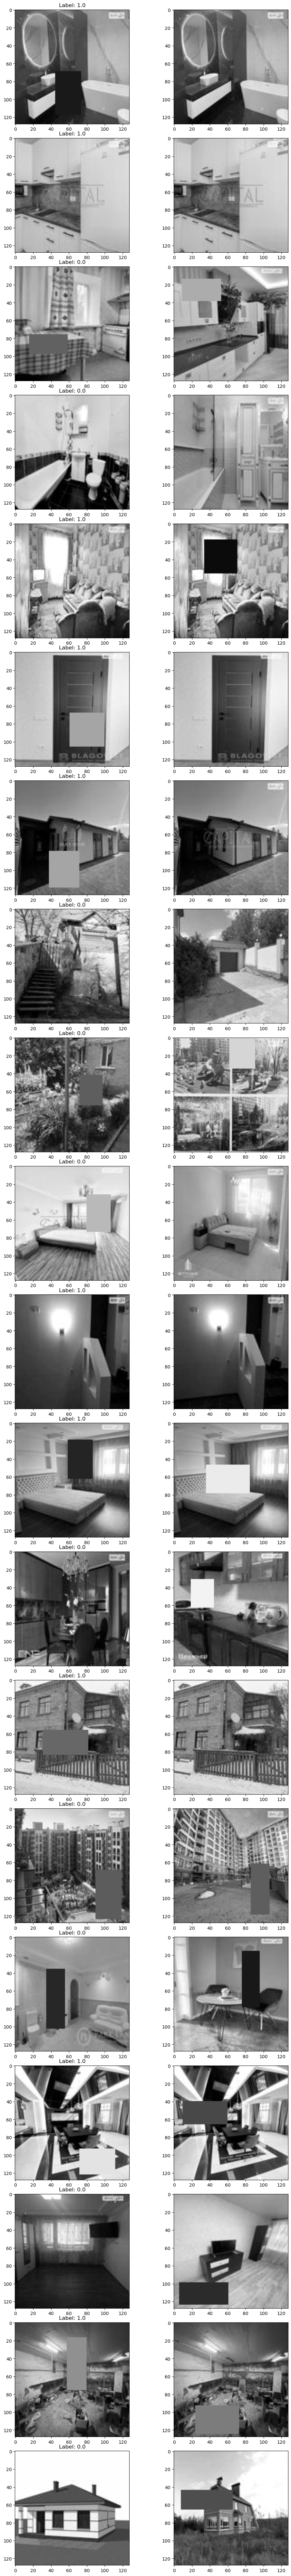

In [13]:
render_random_pairs(train_dataset, 20)

## Model

In [23]:
import torch
from torch import nn
from torchvision.ops import Conv2dNormActivation

In [24]:
class Block(nn.Module):
    def __init__(
        self,
        channels_in,
        channels_out,
        kernel_size,
        dilation,
    ):
        super().__init__()

        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=kernel_size, padding='same', dilation=dilation)
        self.bn1 = nn.BatchNorm2d(channels_out)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        return x

class Level(nn.Module):
    def __init__(
        self,
        layers_n,  # number of repeated layers
        channels_in,
        channels_hidden,
        channels_out,
        kernel_size,
        dilation,
        prepool
    ):
        super().__init__()

        self.layers = nn.Sequential(
            *(
                Block(
                    channels_in if i == 0 else channels_hidden,
                    channels_out if i + 1 == layers_n else channels_hidden,
                    kernel_size=kernel_size,
                    dilation=dilation,
                )
                for i in range(layers_n)
            )
        )

        self.pool = nn.MaxPool2d(2) if prepool else None

    def forward(self, x):
        if self.pool:
            x = self.pool(x)
        x = self.layers(x)
        return x


class Encoder(nn.Module):
    def __init__(
        self,
        expected_size_in,
        all_channels,
        all_layers,  # must be 1 shorter than all_channels
        all_kernel_sizes,  # number of blocks in length
        all_dilation_rates,   # number of blocks in length
        hierarchical_feature_size,
        hierarchical_feature_channels,
        dense_out,
    ):
        super().__init__()

        assert len(all_channels) - 1 == len(all_layers) == len(all_kernel_sizes) == len(all_dilation_rates)

        self.size_in = expected_size_in
        self.h_feat_size = hierarchical_feature_size

        self.levels = nn.ModuleList(
            Level(n, c_in, c_out, c_out, prepool=(i != 0), kernel_size=kernel, dilation=dilation)
            for i, (c_in, c_out, n, kernel, dilation)
            in enumerate(zip(all_channels, all_channels[1:], all_layers, all_kernel_sizes, all_dilation_rates))
        )

        self.feature_convolutions = nn.ModuleList(
            Conv2dNormActivation(c, hierarchical_feature_channels, kernel_size=1)
            for c in all_channels[1:]
        )

        # TODO you can add final convolution to fuse features

        self.final_pool = nn.AvgPool2d(hierarchical_feature_size//2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU(inplace=True)
        self.dense = nn.Linear(2*2*len(all_layers) * hierarchical_feature_channels, dense_out)

    def forward(self, x):
        features = []
        for i, level in enumerate(self.levels):
            x = level(x)
            features.append(nn.AvgPool2d(self.size_in // self.h_feat_size // 2**i)(x))

        unified_features = [self.feature_convolutions[i](feature) for i, feature in enumerate(features)]

        x = torch.cat(unified_features, -3)
        x = self.final_pool(x)
        x = self.flatten(x)
        x = self.relu(x)
        x = self.dense(x)
        return x


class Comparator(nn.Module):
    def __init__(
        self,
        expected_in_dim
    ):
        super().__init__()
        self.layer = nn.Linear(1, 1)
        self.expected_in_dim = expected_in_dim

        state_dict = self.state_dict()
        state_dict['layer.weight'] = torch.tensor([[-1.]])
        state_dict['layer.bias'] = torch.tensor([5.])
        self.load_state_dict(state_dict)

    def forward(self, a, b):
        assert a.shape[-1] == self.expected_in_dim

        dist = torch.pow(a - b, 2).sum(dim=-1, keepdim=True) / self.expected_in_dim
        logit = self.layer(dist).squeeze(-1)
        return logit



class Model(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()

        self.encoder = Encoder(
            128,
            all_channels=[1, 16, 32, 64, 128],
            all_layers=[2, 2, 4, 4],
            all_kernel_sizes=[5, 3, 3, 3],
            all_dilation_rates=[4, 3, 2, 1],
            hierarchical_feature_size=4,
            hierarchical_feature_channels=32,
            dense_out=64,
        )

        self.comparator = Comparator(64)

    def forward(self, x1, x2):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        logit = self.comparator(x1, x2)
        return logit


OrderedDict([('layer.weight', tensor([[-1.]])), ('layer.bias', tensor([5.]))])

In [25]:
model = Model()

torch.Size([2])

In [ ]:
model.comparator.state_dict()

In [26]:
a = torch.rand(2, 1, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
b = torch.rand(2, 1, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
model(a,b).shape

## Training

In [28]:
class PLModel(pl.LightningModule):
    def __init__(
        self, 
        model,
        criterion,
        lr,
        wd=0,
    ):
        super().__init__()
        
        self.model = model
        self.criterion = criterion
        self.lr = lr
        self.wd = wd
        
        self.val_accuracy = Accuracy('binary')
        self.val_recall = Recall('binary')
        self.val_f1 = F1Score('binary')
        self.train_accuracy = Accuracy('binary')
        self.train_recall = Recall('binary')
        self.train_f1 = F1Score('binary')
        
        self.save_hyperparameters()

        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
    
    def forward(self, x1, x2):
        return self.model(x1, x2)
    
    def training_step(self, batch, batch_idx):
        aggregated, y = batch
        x1 = aggregated[:, :1, :, :]
        x2 = aggregated[:, 1:, :, :]
        
        logit = self(x1, x2)
        
        loss = self.criterion(logit, y)
        self.log('train_loss', loss, sync_dist=True)
        preds = 1.*(logit > 0)
        self.train_accuracy(preds, y)
        self.train_recall(preds, y)
        self.train_f1(preds, y)
        return loss

    def validation_step(self, batch, batch_idx):
        aggregated, y = batch
        x1 = aggregated[:, :1, :, :]
        x2 = aggregated[:, 1:, :, :]
        
        logit = self(x1, x2)
        
        loss = self.criterion(logit, y)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True)
        
        preds = 1.*(logit > 0)
        self.val_accuracy(preds, y)
        self.val_recall(preds, y)
        self.val_f1(preds, y)
        return loss
    
    def on_train_epoch_end(self):
        acc = self.train_accuracy.compute()
        recall = self.train_recall.compute()
        f1 = self.train_f1.compute()
        self.log('train_acc', acc)
        self.log('train_recall', recall)
        self.log('train_f1', f1)

    def on_validation_epoch_end(self):
        acc = self.val_accuracy.compute()
        recall = self.val_recall.compute()
        f1 = self.val_f1.compute()
        self.log('val_acc', acc)
        self.log('val_recall', recall)
        self.log('val_f1', f1)

In [29]:
pl_model = PLModel(
    model,
    nn.BCEWithLogitsLoss(),
    1e-3,
    wd=0.0,
)

INFO: CometLogger will be initialized in online mode


In [30]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',  # Metric to monitor for saving the best model
    mode='min',          # Whether to minimize or maximize the monitored metric
    filename='best_model',  # Name of the saved checkpoint file
    save_top_k=3         # Save only the best model (set to 3 to save top 3, for example)
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorflow, keras, torch, tensorboard.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hotsteel1312/hackathon-lun/ee69677bf20f4449b38a3dc636b6a61d



In [31]:
logger = CometLogger(
    api_key='VHZ1D3GixsI0P9LRnDFEHYrAG',
    project_name='hackathon_lun',
    experiment_name='128-erasing-hierarchical-cnn'
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [32]:
logger.log_hyperparams({
    'data_split_seed': DATASET_SPLIT_SEED,
    'train_dataset': "LunGrayscale128",
    'input_image_size': INPUT_IMAGE_SIZE,
    'description': "Hierarchical CNN, val_set 10%"
})

In [33]:
trainer = pl.Trainer(max_epochs=10, val_check_interval=1/2, callbacks=[checkpoint_callback], logger=logger)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | Model             | 709 K 
1 | criterion      | BCEWithLogitsLoss | 0     
2 | val_accuracy   | BinaryAccuracy    | 0     
3 | val_recall     | BinaryRecall      | 0     
4 | val_f1         | BinaryF1Score     | 0     
5 | train_accuracy | BinaryAccuracy    | 0     
6 | train_recall   | BinaryRecall      | 0     
7 | train_f1       | BinaryF1Score     | 0     
-----------------------------------------------------
709 K     Trainable params
0         Non-trainable params
709 K     Total params
2.836     Total estimated model params size (MB)
COMET WARNING: truncated string; too long: 'Model(
  (encoder): Encoder(
    (levels): ModuleList(
      (0): Level(
        (layers): Sequential(
          (0): Block(
            (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same, dilation=(4, 4))
     

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/hotsteel1312/hackathon-lun/ee69677bf20f4449b38a3dc636b6a61d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_acc [10]    : (0.9380099773406982, 0.9872806072235107)
COMET INFO:     train_f1 [10]     : (0.9073650240898132, 0.9801180362701416)
COMET INFO:     train_loss [249]  : (0.001192958210594952, 0.6839296221733093)
COMET INFO:     train_recall [10] : (0.954380452632904, 0.9855485558509827)
COMET INFO:     val_acc [20]      : (0.9532241821289062, 0.9901438355445862)
COMET INFO:     val_f1 [20]       : (0.9282296895980835, 0.9842453002929688)
COMET INFO:     v

In [ ]:
train_dataloader = DataLoader(train_dataset, 64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, 64, shuffle=False, num_workers=2)

In [38]:
trainer.fit(
    pl_model, 
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

## Validation without augmentation

In [40]:
val_dataset.set_transform(val_pair_transform)

In [41]:
trainer.validate(pl_model, dataloaders=val_dataloader, verbose=True)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorflow, keras, torch, tensorboard.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hotsteel1312/hackathon-lun/ee69677bf20f4449b38a3dc636b6a61d



{'web': 'https://www.comet.com/api/asset/download?assetId=58e3e2eae68044929de7ab4f602846cd&experimentKey=ee69677bf20f4449b38a3dc636b6a61d',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=58e3e2eae68044929de7ab4f602846cd&experimentKey=ee69677bf20f4449b38a3dc636b6a61d',
 'assetId': '58e3e2eae68044929de7ab4f602846cd'}

In [ ]:
torch.save(model, 'model.pt')

In [42]:
logger.experiment.log_model("model10epc", "model.pt")

## Render wrongly classified validation entries

In [44]:
class Classify:
    def __init__(self, model):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
    
    def __call__(self, x1, x2):
        return self.get_prob(x1, x2) > .5
    
    def get_prob(self, x1, x2):
        assert x1.shape == x2.shape
        while len(x1.shape) < 4:
            x1 = x1.unsqueeze(0)
            x2 = x2.unsqueeze(0)
        
        x1 = x1.to(self.device)
        x2 = x2.to(self.device)
            
        self.model.eval()
        with torch.no_grad():
            return torch.sigmoid(self.model(x1, x2)).item()

In [45]:
def get_wrongly_classified_idx(dataset, classify):
    misclassified = []
    for i in tqdm(range(len(dataset))):
        aggregated, y = dataset[i]
        x1 = aggregated[:1, :, :]
        x2 = aggregated[1:, :, :]
        
        y_hat = classify(x1, x2)
        
        if y_hat != y:
            misclassified.append(i)
    
    return misclassified

In [46]:
def render_wrongly_classified(dataset, misclassified, classify):
    fig, axes = plt.subplots(len(misclassified), 2, figsize=(10, 4*len(misclassified)))
    fig.tight_layout()
    
    for i, n in enumerate(misclassified):
        x1, x2 = dataset[n][0][0], dataset[n][0][1]
        axes[i,0].imshow(x1, cmap='gray')
        axes[i,1].imshow(x2, cmap='gray')
        
        axes[i,0].set_title('Idx: ' + str(n) + ' Label: ' + str(float(dataset[n][1])))
        axes[i,1].set_title('Pred: ' + str(float(classify.get_prob(x1, x2))))
        

100%|██████████| 8851/8851 [01:11<00:00, 123.00it/s]


In [47]:
classify = Classify(model)

28

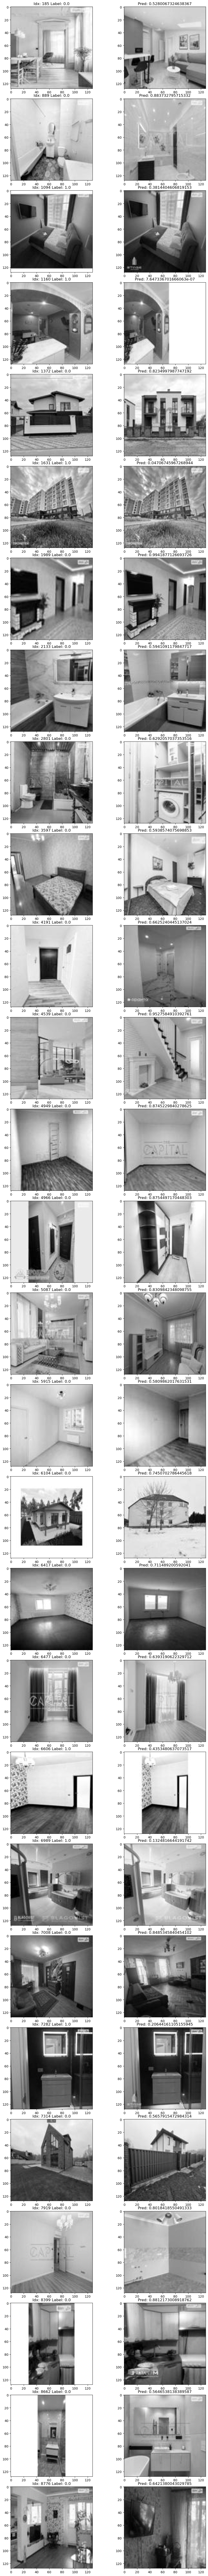

In [48]:
misclassified = get_wrongly_classified_idx(val_dataset, classify)

In [ ]:
len(misclassified)

In [ ]:
render_wrongly_classified(val_dataset, misclassified[:50], classify)

## Predict

In [ ]:
test_dataset = NDTestDataset(
    '/kaggle/input/luntestoriginal/test/test-data-local.csv',
    '/kaggle/input/luntestoriginal/test/images',
    test_pair_transform
)

In [ ]:
def get_predictions(model, dataset):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    predictions = {'ID': [], 'is_same': []}
    dataloader = DataLoader(dataset, 32, num_workers=8)
    
    for idx, x in tqdm(dataloader):
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        
        x = x.to(device)
        
        x1, x2 = x[:, :1, :, :], x[:, 1:, :, :]
        
        logit = model(x1, x2)
        preds = 1*(logit > .0)
        
        for i, pred in zip(idx, preds):
            predictions['ID'].append(int(i))
            predictions['is_same'].append(int(pred))
    return predictions
    

In [ ]:
predictions = get_predictions(model, test_dataset)

In [ ]:
submission_df = pd.DataFrame(predictions)

In [ ]:
submission_df.head()

In [ ]:
len(submission_df)

In [ ]:
submission_df.to_csv('test-submission.csv', index=False)